In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne

from invert.forward import get_info, create_forward_model
from invert.util import pos_from_forward
pp = dict(surface='white', hemi='both', verbose=0)

In [2]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')
pos = pos_from_forward(fwd)
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape

source_model = fwd['src']
vertices = [source_model[0]['vertno'], source_model[1]['vertno']]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


# Simulate

In [3]:
from invert.solvers.esinet import generator

sim_params = dict(
    use_cov=False,
    return_mask=False,
    batch_repetitions=1,
    batch_size=1,
    n_sources=5,
    n_orders=(0, 3),
    snr_range=(4, 5),
    n_timecourses=200,
    n_timepoints=200,
    scale_data=False)

gen = generator(fwd, **sim_params)

No projector specified for this dataset. Please consider the method self.add_proj.


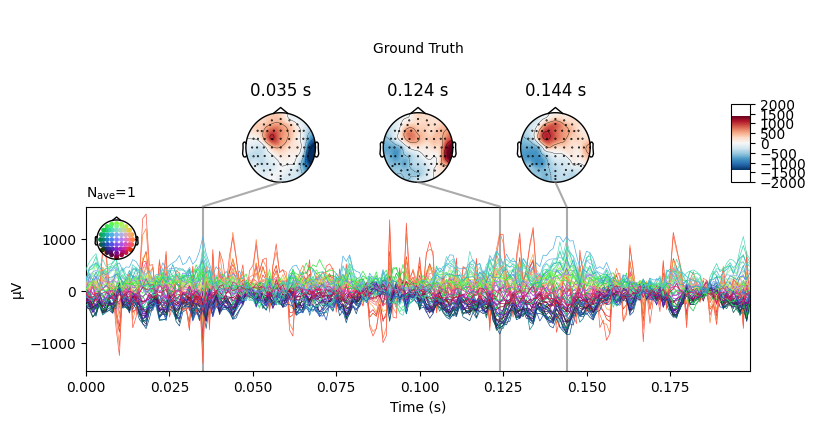

In [4]:
x, y = gen.__next__()

tmin = 0
tstep = 1/info["sfreq"]
subject = "fsaverage"
evoked = mne.EvokedArray(x[0].T, info, tmin=tmin)
stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep, 
                        subject=subject, verbose=0)
                        
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, "Ground Truth", 'title',
               font_size=14)
evoked.plot_joint(title="Ground Truth")

# Solve

In [5]:
from invert import Solver
solver = Solver("flex")
solver.make_inverse_operator(fwd, evoked, alpha="auto", n_orders=3)

stc_ = solver.apply_inverse_operator(evoked)

# stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print("r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])
print("L1 = ",  np.linalg.norm(stc_.data, ord=1))

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
r =  0.6203072036189745
L1 =  0.0030251505282249173


In [6]:
from invert import Solver
solver = Solver("trap")
solver.make_inverse_operator(fwd, evoked, alpha="auto", n_orders=3)

stc_ = solver.apply_inverse_operator(evoked)

# stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print("r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])
print("L1 = ",  np.linalg.norm(stc_.data, ord=1))

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
r =  0.3813473976333057
L1 =  0.003366906180469703


In [8]:
from invert import Solver
solver = Solver("rap")
solver.make_inverse_operator(fwd, evoked, alpha="auto", n_orders=3)

stc_ = solver.apply_inverse_operator(evoked)

# stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print("r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])
print("L1 = ",  np.linalg.norm(stc_.data, ord=1))

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
r =  0.738272046474743
L1 =  0.0033473542026616924


Using control points [0.         0.         0.00038094]
Using control points [0.00000000e+00 7.69275747e-07 5.90279176e-04]


# Big Loop

In [ ]:
from invert import Solver
# from invert.config import all_solvers
from invert.evaluate import nmse, corr, eval_mean_localization_error, eval_auc
from invert.adapters import contextualize_bd
import pickle as pkl


all_solvers = [ "MNE", "wMNE", "dSPM", "FISTA", "L1L2",
                "LORETA", "sLORETA", "eLORETA", 
                "LAURA", "Backus-Gilbert", 
                "S-MAP",
                "Champagne", "Multiple Sparse Priors", "Bayesian LORETA", "Bayesian MNE", "Bayesian Beamformer", "Bayesian Beamformer LORETA",
                "BCS", "Gamma-MAP", "Source-MAP", "Gamma-MAP-MSP", "Source-MAP-MSP",
                "MVAB", "LCMV", "SMV", "WNMV", "HOCMV", "ESMV", "MCMV", "ESMCMV", "ReciPSIICOS", "SAM",
                # "Fully-Connected", 
                # "LUCAS",
                # "OMP", "COSAMP", "SOMP", "REMBO", "SP", "SSP",
                # "SMP", "SSMP", "SubSMP",
                "EPIFOCUS",
                "MUSIC", "RAP-MUSIC", "TRAP-MUSIC", "JAZZ-MUSIC",
            ]
redo_solvers = np.array(["Champagne", "Multiple Sparse Priors", 
            "Bayesian LORETA", "Bayesian MNE", "Bayesian Beamformer", 
            "Bayesian Beamformer LORETA", "Gamma-MAP", "Source-MAP"])

all_solvers = ["TRAP-MUSIC", "JAZZ-MUSIC", "LCMV", "sLORETA"]

settings = dict(
    number_of_sources=(1, 10), 
    extents=(1, 25), 
    duration_of_trial=1, 
    target_snr=(1, 100))
alpha = "auto"

errors_corr = {sname: [] for sname in all_solvers}
errors_mle = {sname: [] for sname in all_solvers}
errors_auc = {sname: [] for sname in all_solvers}
errors_nmse = {sname: [] for sname in all_solvers}

solvers = dict()
sim = Simulation(fwd, info, settings).simulate(100)
    
for i in range(sim.n_samples):
    print(i)
    stc = sim.source_data[i]
    evoked = sim.eeg_data[i].average()

    for solver_name in all_solvers :
        print(solver_name)
        solver = Solver(solver=solver_name)
        if (not solver_name in solvers) or solver_name in redo_solvers:
            if solver_name == "Fully-Connected":
                solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha=alpha, settings=dict(duration_of_trial=0., target_snr=settings["target_snr"], extents=settings["extents"]), n_simulations=5000)
            else:
                solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha=alpha)
        # stc_hat.plot(**pp, brain_kwargs=dict(title=solver.name))
        # error = np.mean(corr(stc.data, stc_hat.data))
        
        try:
            stc_hat = solvers[solver_name].apply_inverse_operator(evoked)
            error_corr = np.mean(corr(stc.data, stc_hat.data))

            error_mle = eval_mean_localization_error(stc.data[:, 0], stc_hat.data[:, 0], pos)
            error_auc = eval_auc(stc.data[:, 0], stc_hat.data[:, 0], pos)
            error_nmse = np.median(nmse(stc.data, stc_hat.data))

        except:
            print("\t...didnt work this time")
            error_mle = np.nan
            error_auc = np.nan
            error_corr = np.nan
            error_nmse = np.nan

        errors_corr[solver_name].append( error_corr )
        errors_mle[solver_name].append( error_mle )
        errors_auc[solver_name].append( error_auc )
        errors_nmse[solver_name].append( error_nmse )


    print("Saving errors")
    fn = "errors.pkl"
    with open(fn, 'wb') as f:
        pkl.dump([errors_corr, errors_mle, errors_auc, errors_nmse, sim.simulation_info], f)

In [ ]:
# import pickle as pkl
# fn = "errors.pkl"
# with open(fn, 'rb') as f:
#     errors_corr, errors_mle, errors_auc = pkl.load(f)

In [ ]:
# for key, val in errors_mle.items():
#     errors_mle[key] = val[:31]

# for key, val in errors_corr.items():
#     errors_mle[key] = val[:31]

# for key, val in errors_auc.items():
#     errors_mle[key] = val[:31]
    

# Plot

In [ ]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=0.8)
errors = [errors_corr, errors_mle, errors_auc, errors_nmse]
error_names = ["errors_corr", "errors_mle", "errors_auc", "errors_nmse"]
for error, error_name in zip(errors, error_names):
    df = pd.DataFrame(error)


    sorted_index = df.median().sort_values().index
    df = df[sorted_index]

    plt.figure()
    sns.boxplot(data=df)
    plt.title(error_name)


# df_mean_var = pd.concat([df.mean(), df.std()], axis=1)
# df_mean_var = df_mean_var.rename(columns={0: "Median", 1: "Variance"})
# df_mean_var["MedVar"] = df_mean_var["Median"] / df_mean_var["Variance"]
# df_mean_var["Method"] = df_mean_var.index
# df_mean_var = df_mean_var.sort_values(by="Median")
# display(df_mean_var)

# plt.figure()
# sns.scatterplot(x="Median", y="Variance", hue="Method", size="MedVar", data=df_mean_var)
# plt.xlabel("Median")
# plt.ylabel("Variance")


In [ ]:
settings = dict(number_of_sources=3, extents=(25, 35), duration_of_trial=0.025, target_snr=99999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)